In [1]:
import os
from dose_reponse_fit import dose_response_fit, ModelPredictions, survival_to_stress, StandardSettings
# from plotting import plot_complete
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from data_formats import read_data
from plotting import plot_fit_prediction
from stress_survival_conversion import stress_to_survival, survival_to_stress

In [2]:
dfs = []

for path in os.listdir("data"):
    
    data = read_data(f"data/{path}")
    
    meta = data.meta
    res : ModelPredictions = dose_response_fit(data.main_series, StandardSettings(beta_q=3.2, beta_p=3.2, param_d_norm=True, survival_max= meta.max_survival))
    
    title = f"{meta.chemical} - {meta.organism}"
    
    dfs.append({"title" : path[:-4], "chemical":meta.chemical, "organism":meta.organism, "model": res})

df = pd.DataFrame(dfs)
df.head()    

,title,chemical,organism,model
0,naeem_Esfenvalerate_2019.,Esfenvalerate,Daphnia magna,ModelPredictions(concentration_curve=array([1....
1,ayesha-cloth_Clothianidin_2024_agricultural_pr...,Clothianidin,Gammarus pulex,ModelPredictions(concentration_curve=array([1....
2,naeem_Esfenvalerate_2024.,Esfenvalerate,Daphnia magna,ModelPredictions(concentration_curve=array([1....
3,bps_esf_food_2024.,BPS,Daphnia magna,ModelPredictions(concentration_curve=array([1....
4,ayesha-cloth_Clothianidin_2024_reference_pre-c...,Clothianidin,Gammarus pulex,ModelPredictions(concentration_curve=array([1....


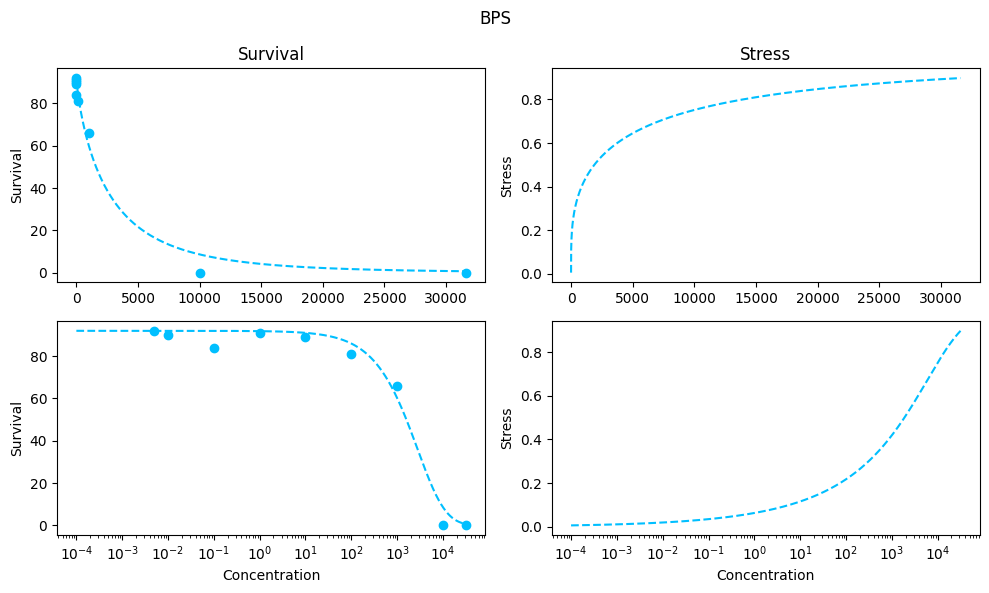

In [3]:
row = df.sample(1, random_state=4).iloc[0]
fig = plot_fit_prediction(row.model, row.chemical)

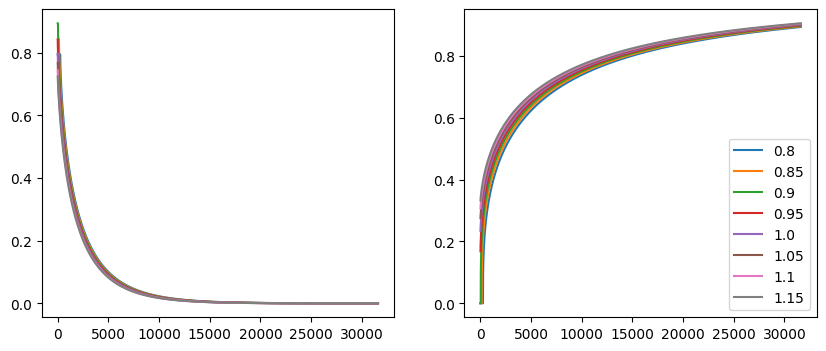

In [4]:
temps = np.arange(0.8,1.2,0.05)
temps = np.round(temps, 2)

model : ModelPredictions = row.model

fig, ax = plt.subplots(1,2, figsize = (10,4))

for temp in temps:
    
    normed = model.survival_curve / model.cfg.survival_max / temp
    
    stress = survival_to_stress(normed)

    back = stress_to_survival(stress+ 0.1) * temp
    
    ax[0].plot(model.concentration_curve, back, label = temp)    
    ax[1].plot(model.concentration_curve, stress, label = temp)    

ax[1].legend()

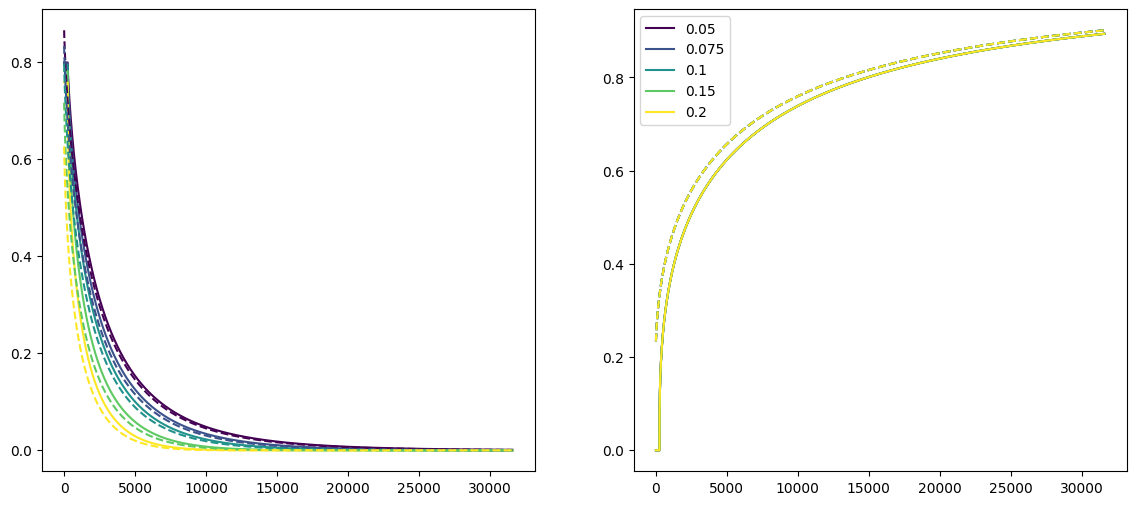

In [5]:
import matplotlib.pyplot as plt

# Define the stress factors and assign specific colors to each
stress_facs = [0.05, 0.075, 0.1, 0.15, 0.2]
colors = plt.cm.viridis([0, 0.25, 0.5, 0.75, 1])  # Generate a color map with 5 colors

fig, ax = plt.subplots(1, 2, figsize=(14, 6))

temp = 0.8

# Plot with temp = 0.85
for s, color in zip(stress_facs, colors):
    normed = model.survival_curve / model.cfg.survival_max / temp
    stress = survival_to_stress(normed)
    back = stress_to_survival(stress + s) * temp
    
    ax[0].plot(model.concentration_curve, back, label=f'{s}', color=color)
    ax[1].plot(model.concentration_curve, stress, label=f'{s}', color=color)

temp = 1

# Plot with temp = 1 (dashed lines)
for s, color in zip(stress_facs, colors):
    normed = model.survival_curve / model.cfg.survival_max / temp
    stress = survival_to_stress(normed)
    back = stress_to_survival(stress + s) * temp
    
    ax[0].plot(model.concentration_curve, back, linestyle='dashed', color=color)
    ax[1].plot(model.concentration_curve, stress, linestyle='dashed', color=color)

ax[1].legend()
plt.show()


In [6]:
survival_to_stress(0.0005)

np.float64(0.9571219877882319)

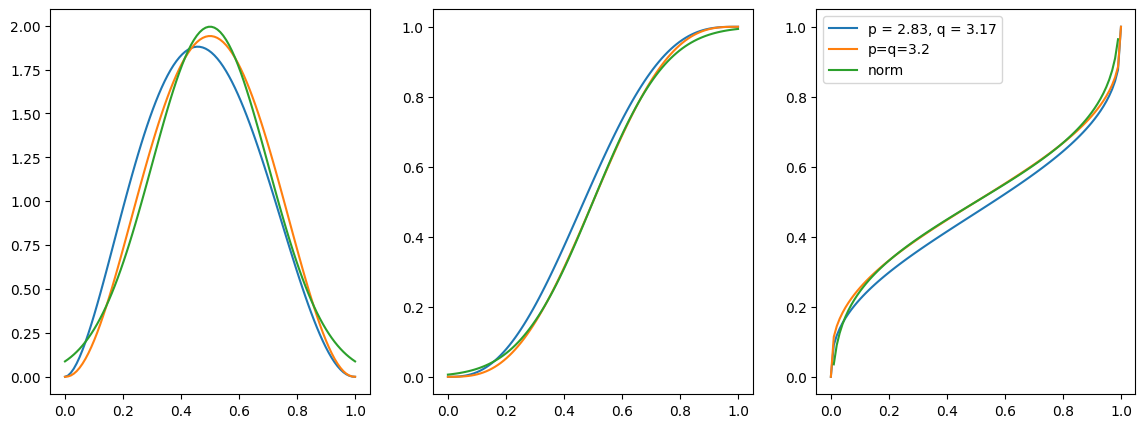

In [7]:
from scipy.stats import beta, norm

p,q = 2.83 ,  3.17

# plot the distribution
plt.figure(figsize=(14, 5))
plt.subplot(131)
x = np.linspace(0, 1, 100)
plt.plot(x, beta.pdf(x, p, q), label = f"p = {p}, q = {q}")
plt.plot(x, beta.pdf(x, 3.2, 3.2), label = "p=q=3.2")
plt.plot(x, norm.pdf(x, loc = 0.5, scale = 0.2), label = "norm")

plt.subplot(132)
# also cdf
plt.plot(x, beta.cdf(x, p, q), label = f"p = {p}, q = {q}")
plt.plot(x, beta.cdf(x, 3.2, 3.2), label = "p=q=3.2")
plt.plot(x, norm.cdf(x, loc = 0.5, scale = 0.2), label = "norm")

plt.subplot(133)
# also cdf
plt.plot(x, beta.ppf(x, p, q), label = f"p = {p}, q = {q}")
plt.plot(x, beta.ppf(x, 3.2, 3.2), label = "p=q=3.2")
plt.plot(x, norm.ppf(x, loc = 0.5, scale = 0.2), label = "norm")

plt.legend()
plt.show()

In [8]:
import glob
from stress_addition_model import sam_prediction, Predicted_LCs, get_sam_lcs, SAM_Setting
from helpers import compute_lc, find_lc_99_max, compute_lc_from_curve
from plotting import plot_sam_prediction
from data_formats import ExperimentData, read_data
import os
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.metrics import mean_squared_error, r2_score
from dataclasses import dataclass
from tqdm import tqdm

In [9]:
@dataclass
class Prediction:
    data: ExperimentData
    main_fit: ModelPredictions
    stressor_fit: ModelPredictions
    best_stress: float
    best_pred: np.ndarray[np.float32]
    stressor_name: str


paths = glob.glob("data/*.xlsx")

settings = SAM_Setting(param_d_norm=False)

results: list[Prediction] = []

for p in tqdm(paths):
    
    data = read_data(p)
    
    for name, val in data.additional_stress.items():

        main_series, stressor_series, meta = data.main_series, val, data.meta

        dose_cfg = StandardSettings(
            survival_max=meta.max_survival,
            beta_q=settings.beta_q,
            beta_p=settings.beta_p,
            param_d_norm=settings.param_d_norm,
        )

        main_fit = dose_response_fit(main_series, cfg=dose_cfg)
        stressor_fit = dose_response_fit(stressor_series, cfg=dose_cfg)

        goal = stressor_fit.survival_curve

        def get_pred(stress):

            return (
                stress_to_survival(main_fit.stress_curve + stress) * meta.max_survival
            )

        def mse(y, y_pred):

            return np.square(y - y_pred).sum(axis=-1)

        stresses = np.linspace(0, 0.7, 150)

        preds = np.array([get_pred(s) for s in stresses])
        losses = mse(goal[None,], preds)

        best_stress_arg = np.argmin(losses)
        best_pred = preds[best_stress_arg]

        results.append(
            Prediction(
                data=data,
                main_fit=main_fit,
                stressor_fit=stressor_fit,
                best_stress=stresses[best_stress_arg],
                best_pred=best_pred,
                stressor_name=name,
            )
        )
        print(stresses[best_stress_arg])


def plot_pred(pred: Prediction):

    x = pred.main_fit.concentration_curve

    plt.title(f"{pred.data.meta.chemical} -  {pred.stressor_name}")
    plt.plot(x, pred.stressor_fit.survival_curve, label="goal")
    plt.plot(x, pred.main_fit.survival_curve, label="surv")
    plt.plot(x, pred.best_pred, label="pred")

    plt.legend()
    plt.show()

  0%|          | 0/13 [00:00<?, ?it/s]

0.0
0.07046979865771812
0.08456375838926174
0.15973154362416106
0.2677852348993288
0.33825503355704695


  8%|▊         | 1/13 [00:05<01:09,  5.77s/it]

0.39463087248322143
0.07986577181208053


 15%|█▌        | 2/13 [00:07<00:36,  3.33s/it]

0.17382550335570468
0.15973154362416106
0.07986577181208053


 23%|██▎       | 3/13 [00:09<00:29,  2.93s/it]

0.2536912751677852
0.14093959731543623
0.03758389261744966


 31%|███       | 4/13 [00:12<00:24,  2.76s/it]

0.15033557046979865
0.07516778523489932


 38%|███▊      | 5/13 [00:13<00:18,  2.29s/it]

0.20201342281879192
0.08926174496644294


 46%|████▌     | 6/13 [00:15<00:13,  2.00s/it]

0.1268456375838926
0.0
0.04228187919463087
0.09865771812080536
0.10335570469798656
0.15503355704697985
0.14563758389261744
0.1785234899328859


 62%|██████▏   | 8/13 [00:21<00:12,  2.47s/it]

0.17382550335570468
0.009395973154362415
0.20671140939597313
0.27718120805369123


 69%|██████▉   | 9/13 [00:24<00:10,  2.69s/it]

0.009395973154362415
0.08456375838926174


 77%|███████▋  | 10/13 [00:25<00:07,  2.37s/it]

0.14093959731543623
0.01879194630872483
0.0610738255033557
0.08456375838926174
0.1221476510067114
0.14563758389261744
0.09865771812080536
0.13624161073825503


 85%|████████▍ | 11/13 [00:31<00:06,  3.25s/it]

0.14563758389261744


100%|██████████| 13/13 [00:32<00:00,  2.49s/it]

0.07516778523489932


In [10]:
paths

['data/naeem_Esfenvalerate_2019.xlsx',
 'data/ayesha-cloth_Clothianidin_2024_agricultural_pre-contamination.xlsx',
 'data/naeem_Esfenvalerate_2024.xlsx',
 'data/bps_esf_food_2024.xlsx',
 'data/ayesha-cloth_Clothianidin_2024_reference_pre-contamination.xlsx',
 'data/ayesha-cloth_Clothianidin_2024_reference.xlsx',
 'data/imrana_2024_food.xlsx',
 'data/naemm_Clothianidin_2024_agricultural.xlsx',
 'data/liess_copper_2001.xlsx',
 'data/ayesha-cloth_Clothianidin_2024_agricultural.xlsx',
 'data/naemm_Clothianidin_2024_reference.xlsx',
 'data/imrana_salt_2024.xlsx',
 'data/imrana_copper_2024.xlsx']

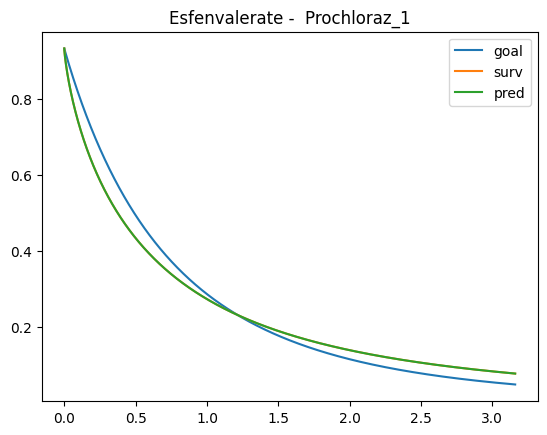

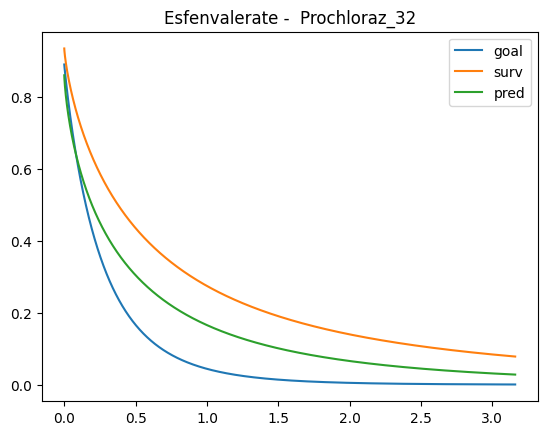

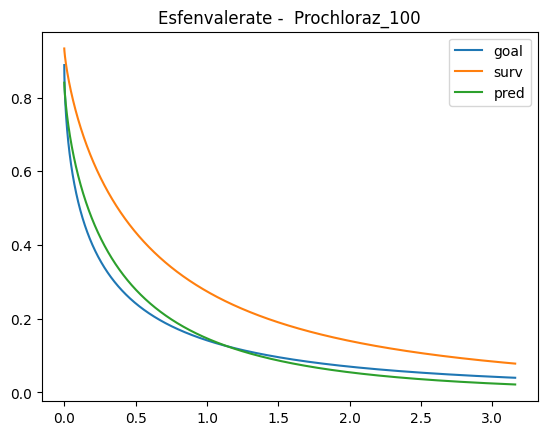

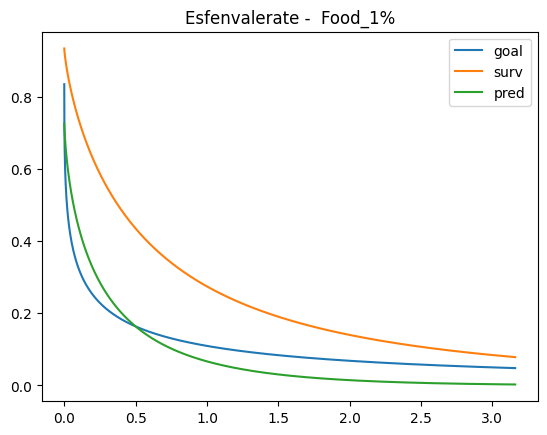

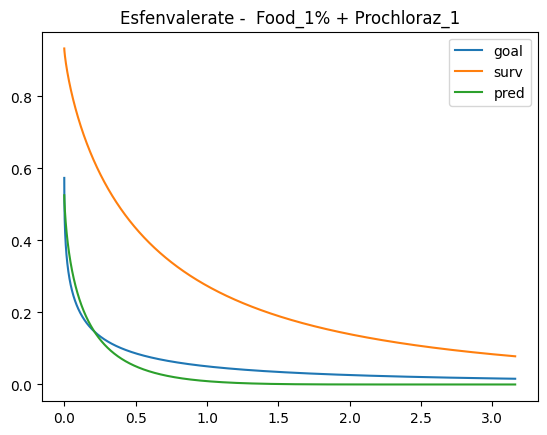

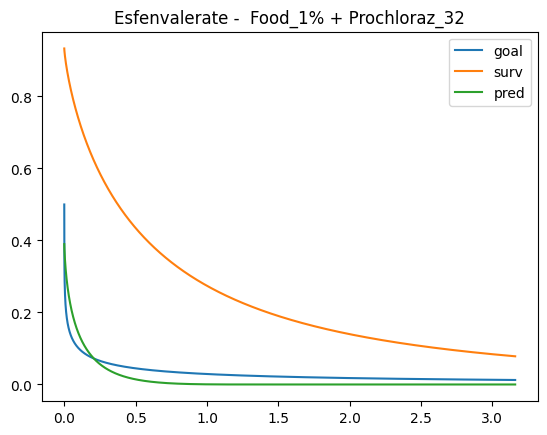

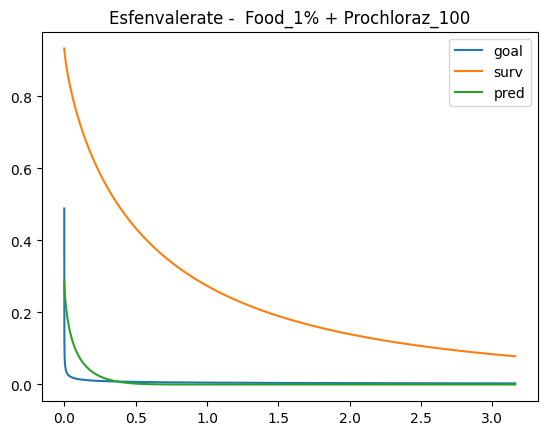

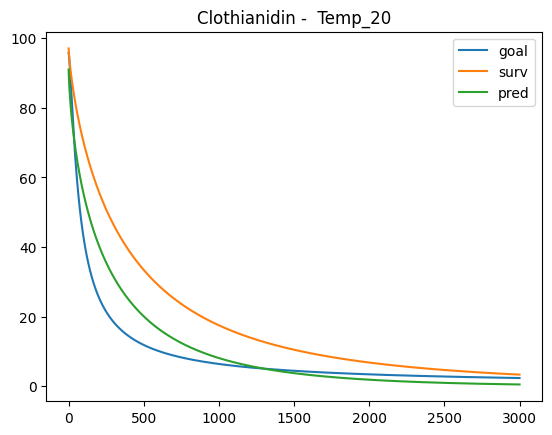

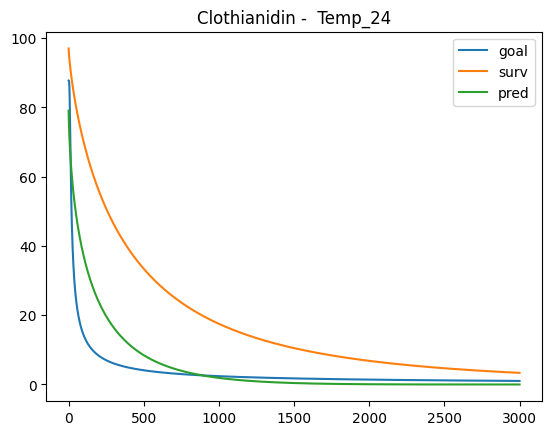

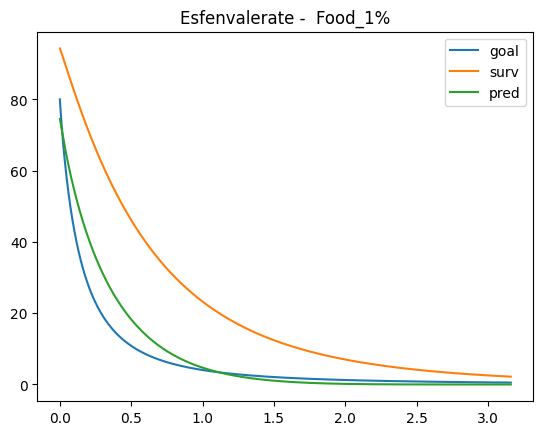

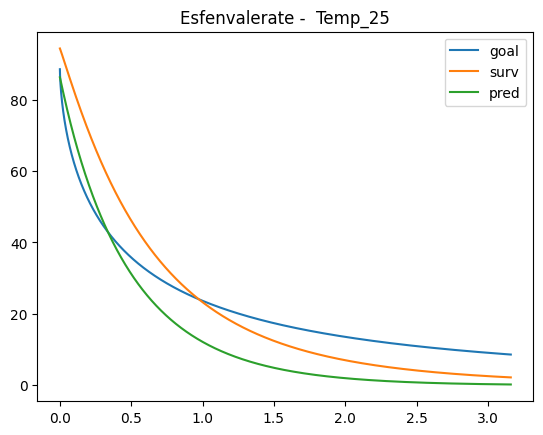

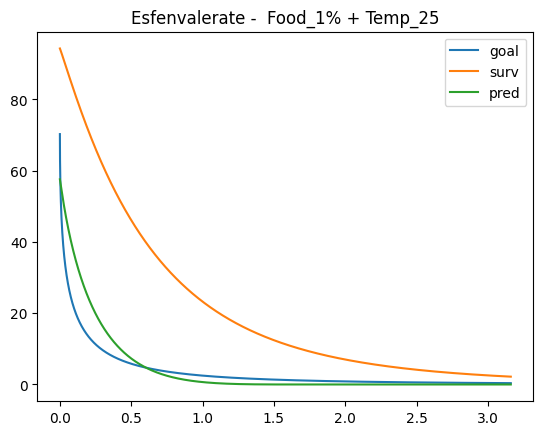

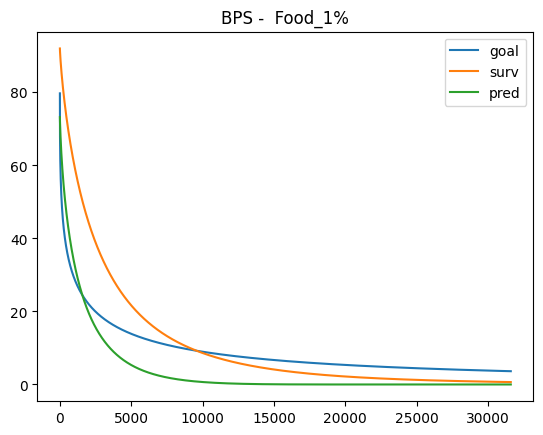

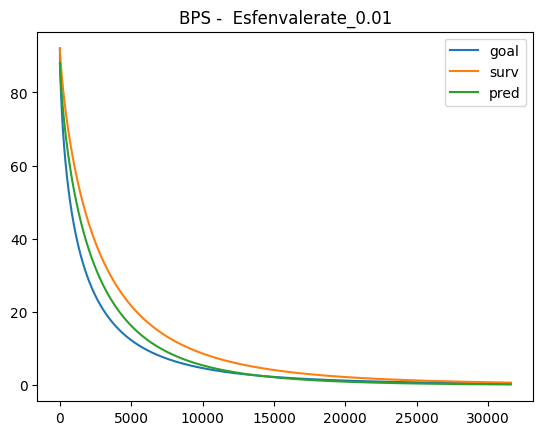

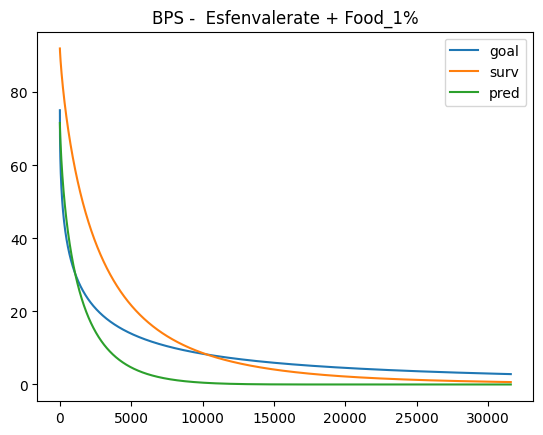

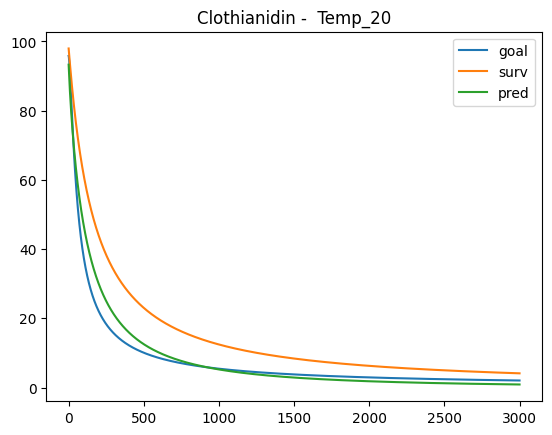

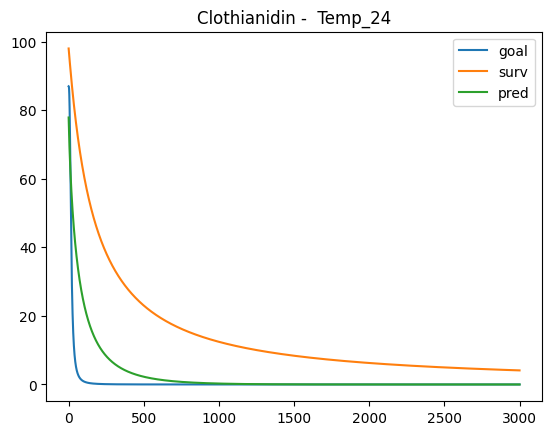

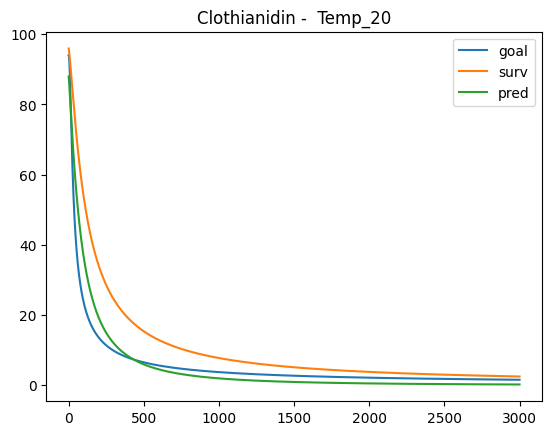

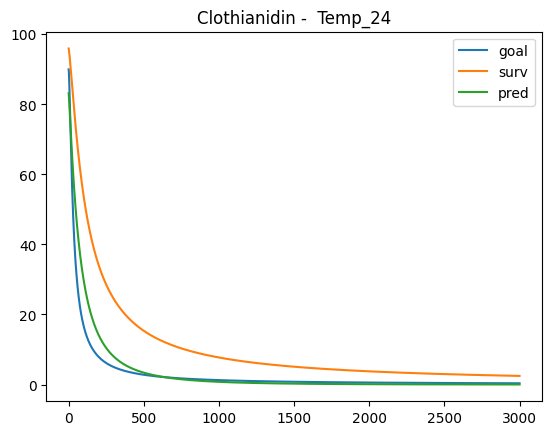

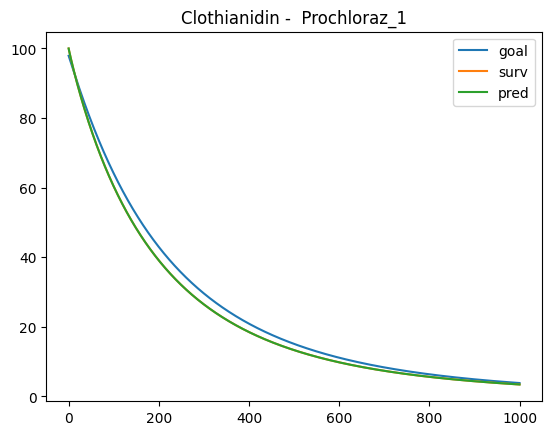

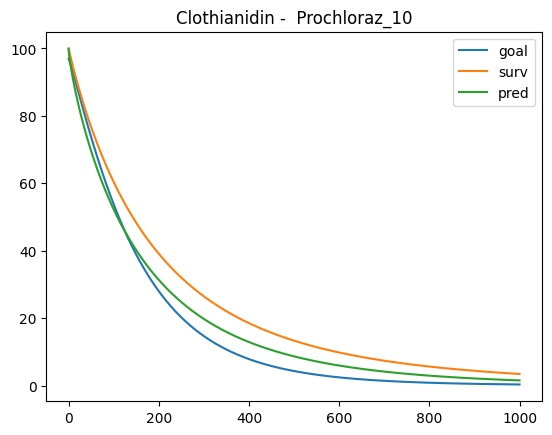

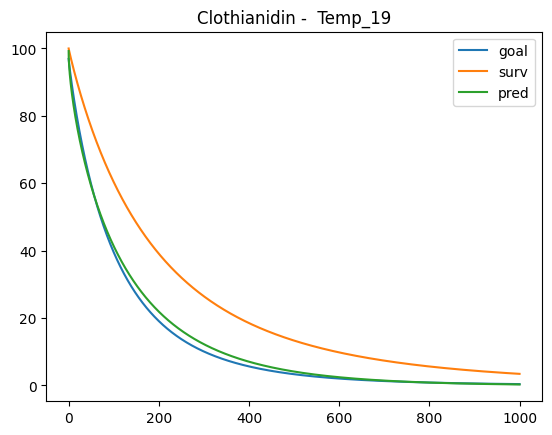

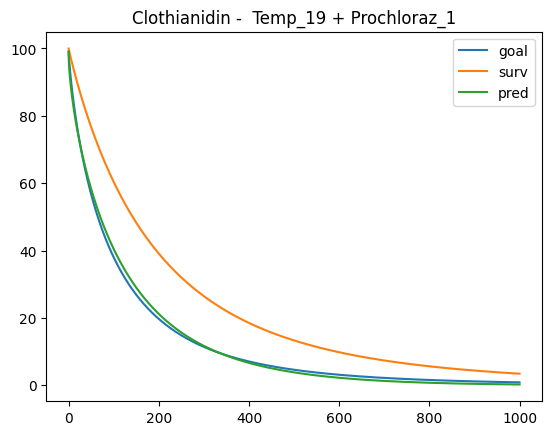

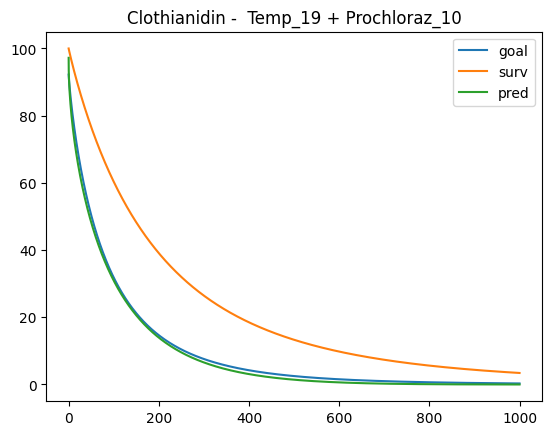

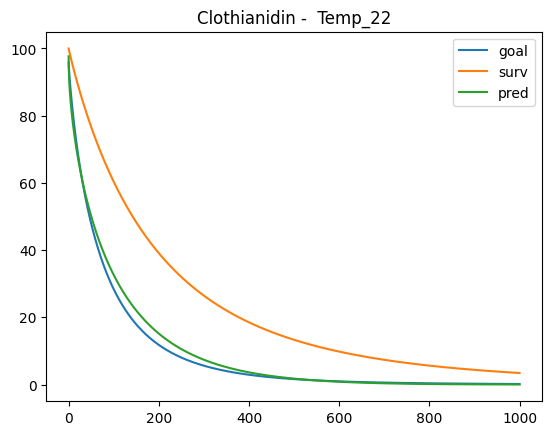

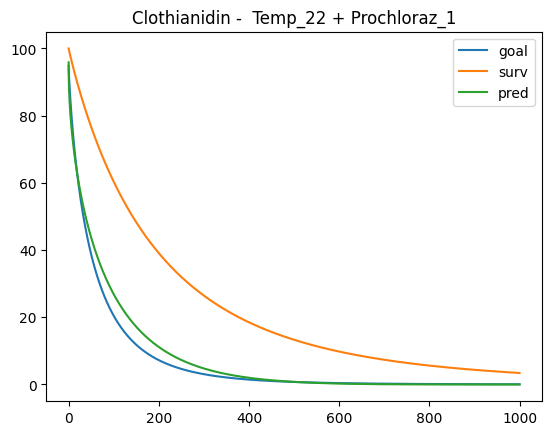

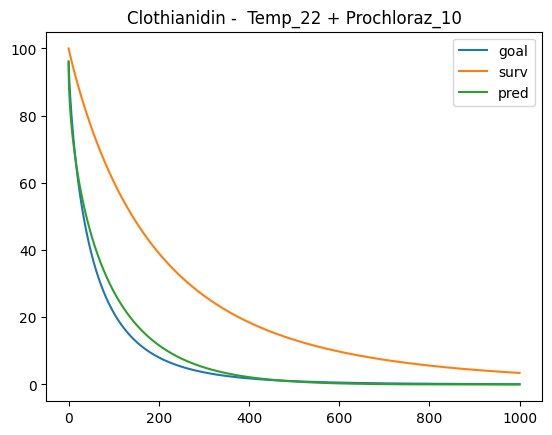

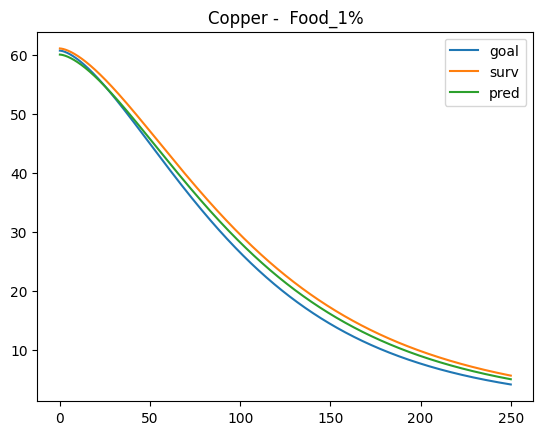

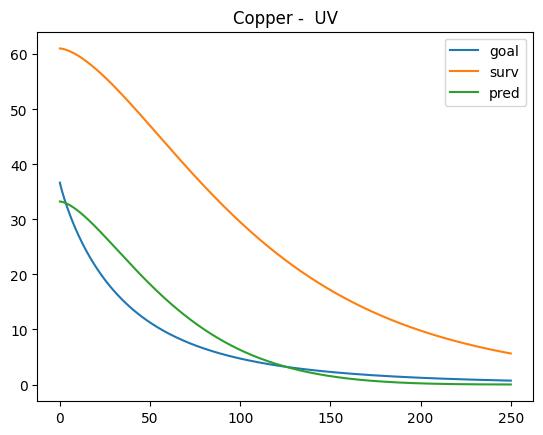

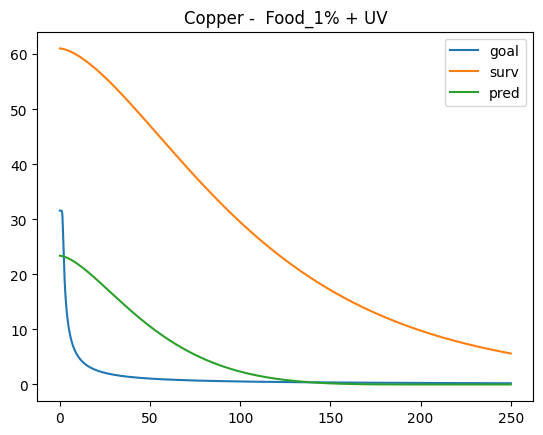

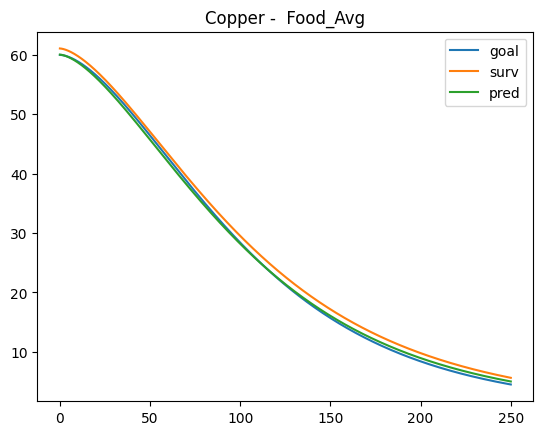

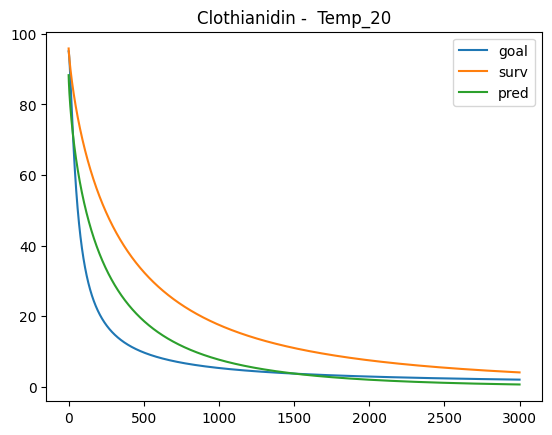

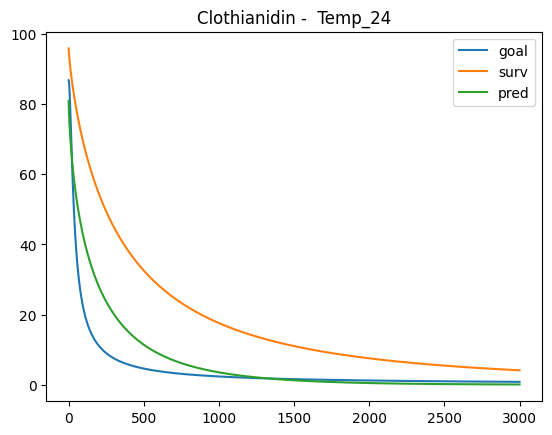

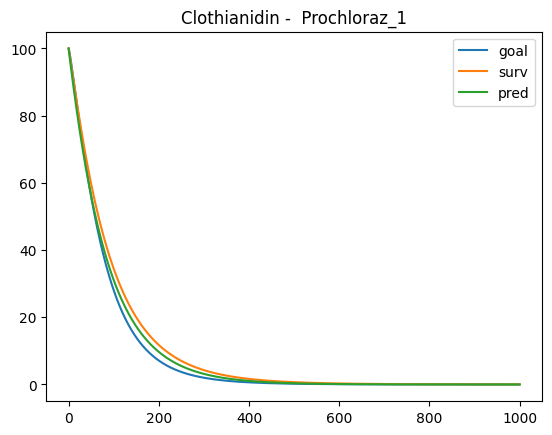

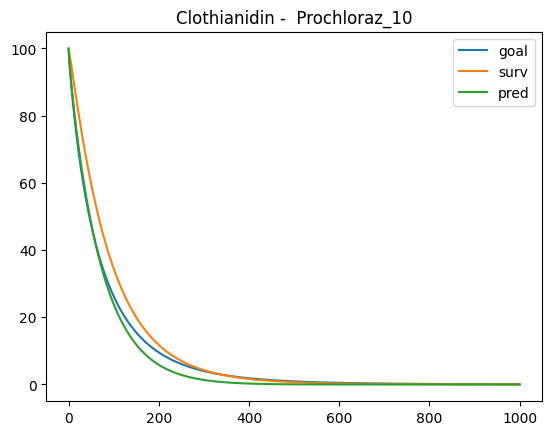

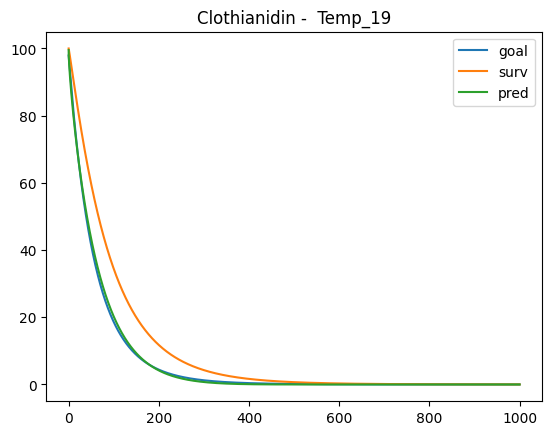

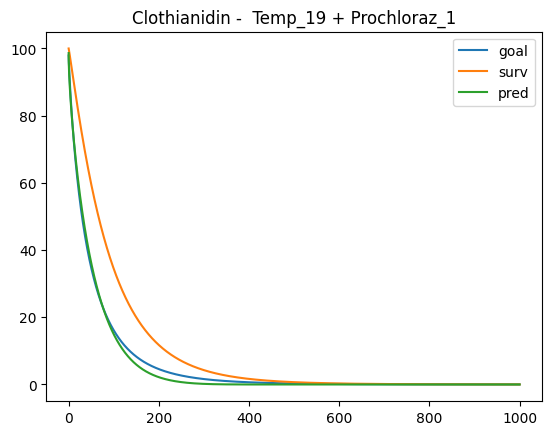

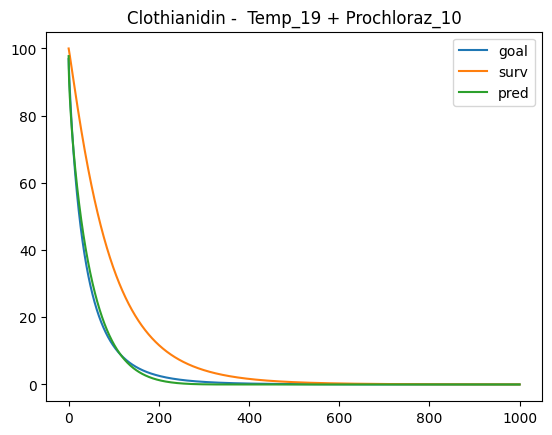

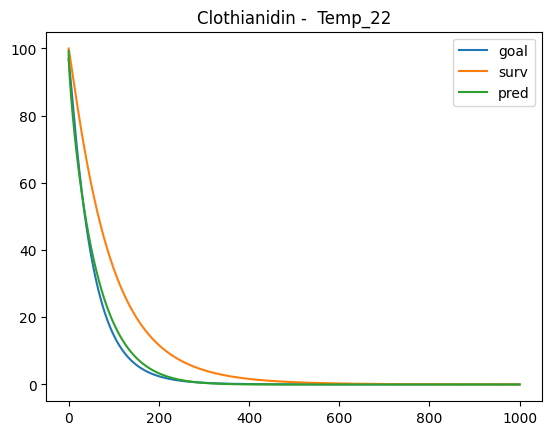

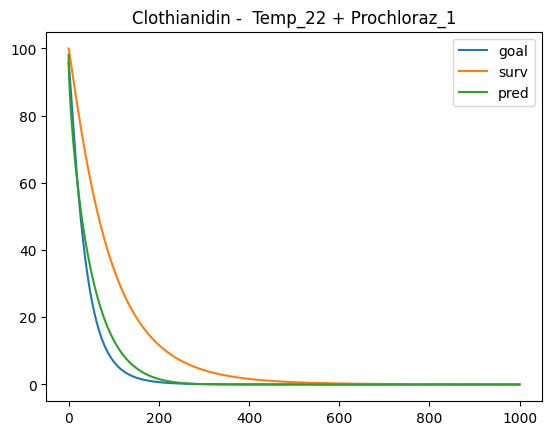

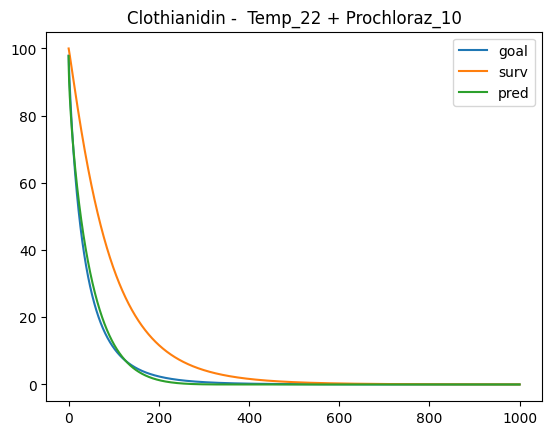

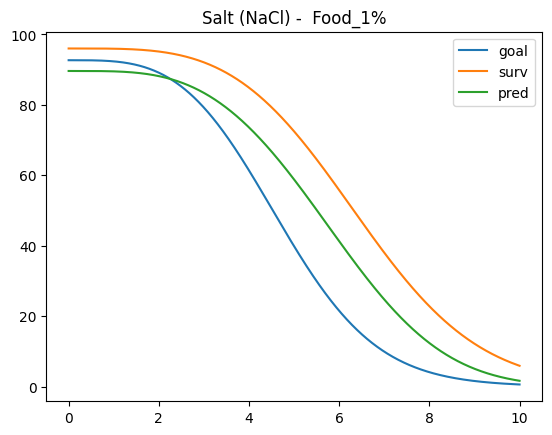

In [11]:
for r in results:
    
    plot_pred(r)

In [12]:
df = pd.DataFrame({
    "d_main" : [r.main_fit.optim_param["d"] for r in results],
    "d_stress" : [r.stressor_fit.optim_param["d"] for r in results],
    "best" : [r.best_stress for r in results],
    "path" : [r.data.meta.path for r in results],
    "stress" : [r.stressor_name for r in results],
    "chemical" : [r.data.meta.chemical for r in results],
})

df

,d_main,d_stress,best,path,stress,chemical
0,0.933333,0.933333,0.000000,data/naeem_Esfenvalerate_2019.xlsx,Prochloraz_1,Esfenvalerate
1,0.933333,0.888889,0.070470,data/naeem_Esfenvalerate_2019.xlsx,Prochloraz_32,Esfenvalerate
2,0.933333,0.888889,0.084564,data/naeem_Esfenvalerate_2019.xlsx,Prochloraz_100,Esfenvalerate
3,0.933333,0.844444,0.159732,data/naeem_Esfenvalerate_2019.xlsx,Food_1%,Esfenvalerate
4,0.933333,0.577778,0.267785,data/naeem_Esfenvalerate_2019.xlsx,Food_1% + Prochloraz_1,Esfenvalerate
5,0.933333,0.533333,0.338255,data/naeem_Esfenvalerate_2019.xlsx,Food_1% + Prochloraz_32,Esfenvalerate
6,0.933333,0.488889,0.394631,data/naeem_Esfenvalerate_2019.xlsx,Food_1% + Prochloraz_100,Esfenvalerate
7,0.970530,0.957080,0.079866,data/ayesha-cloth_Clothianidin_2024_agricultur...,Temp_20,Clothianidin
8,0.970530,0.877680,0.173826,data/ayesha-cloth_Clothianidin_2024_agricultur...,Temp_24,Clothianidin
9,0.942857,0.800000,0.159732,data/naeem_Esfenvalerate_2024.xlsx,Food_1%,Esfenvalerate


In [13]:
mask = np.logical_or(df.d_main <= df.d_stress ,  df.best == 0)
df.loc[mask]

,d_main,d_stress,best,path,stress,chemical
0,0.933333,0.933333,0.000000,data/naeem_Esfenvalerate_2019.xlsx,Prochloraz_1,Esfenvalerate
13,0.920000,0.920000,0.037584,data/bps_esf_food_2024.xlsx,Esfenvalerate_0.01,BPS
19,1.000000,0.979000,0.000000,data/naemm_Clothianidin_2024_agricultural.xlsx,Prochloraz_1,Clothianidin
33,1.000000,1.000000,0.018792,data/naemm_Clothianidin_2024_reference.xlsx,Prochloraz_1,Clothianidin
34,1.000000,1.000000,0.061074,data/naemm_Clothianidin_2024_reference.xlsx,Prochloraz_10,Clothianidin


In [14]:
df = df.loc[~mask]

In [15]:
df.d_main.describe()

count    37.000000
mean      0.951956
std       0.055979
min       0.814187
25%       0.933333
50%       0.959590
75%       1.000000
max       1.000000
Name: d_main, dtype: float64

In [37]:
df.d_main

1     0.933333
2     0.933333
3     0.933333
4     0.933333
5     0.933333
6     0.933333
7     0.970530
8     0.970530
9     0.942857
10    0.942857
11    0.942857
12    0.920000
14    0.920000
15    0.979820
16    0.979820
17    0.959590
18    0.959590
20    1.000000
21    1.000000
22    1.000000
23    1.000000
24    1.000000
25    1.000000
26    1.000000
27    0.814187
28    0.814187
29    0.814187
30    0.814187
31    0.958585
32    0.958585
35    1.000000
36    1.000000
37    1.000000
38    1.000000
39    1.000000
40    1.000000
41    0.960000
Name: d_main, dtype: float64

np.float64(1.8534997881944342)

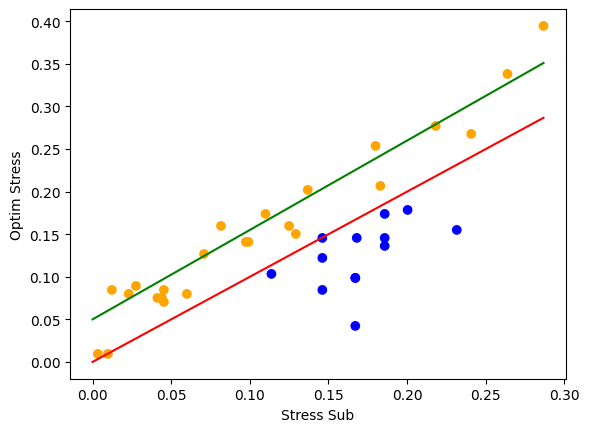

In [53]:
pred = survival_to_stress(df.d_stress) - survival_to_stress(df.d_main)

colors = ["orange" if q < 0.98 else "blue" for q in df.d_main]

plt.scatter(pred, df.best, c = colors)

x = np.linspace(0, pred.max(), 30)
y_line = 20/20 * x
plt.plot(x, y_line, c = "red")
plt.xlabel("Stress Sub")
plt.ylabel("Optim Stress")

y_line_2 = 21/20 * x + 0.05
plt.plot(x, y_line_2, c = "green")


mask = pred * 19/20 > df.best

(df.loc[~mask].best / pred[~mask]).mean()

In [49]:
pred[~mask]

array([0.04534018, 0.04534018, 0.08167432, 0.24074683, 0.26381487,
       0.28672236, 0.02301982, 0.10996507, 0.12498026, 0.0599704 ,
       0.17992953, 0.09908605, 0.12924726, 0.04120145, 0.1368078 ,
       0.02759571, 0.07087425, 0.0033421 , 0.18298535, 0.21820725,
       0.00978152, 0.01227091, 0.09744367, 0.14610423, 0.04410542])

In [48]:
df.loc[~mask].best

1     0.070470
2     0.084564
3     0.159732
4     0.267785
5     0.338255
6     0.394631
7     0.079866
8     0.173826
9     0.159732
10    0.079866
11    0.253691
12    0.140940
14    0.150336
15    0.075168
16    0.202013
17    0.089262
18    0.126846
27    0.009396
28    0.206711
29    0.277181
30    0.009396
31    0.084564
32    0.140940
40    0.145638
41    0.075168
Name: best, dtype: float64

In [47]:
df.loc[~mask].best / pred[~mask]

1     1.554246
2     1.865095
3     1.955713
4     1.112311
5     1.282168
6     1.376352
7     3.469435
8     1.580734
9     1.278054
10    1.331753
11    1.409948
12    1.422396
14    1.163162
15    1.824396
16    1.476622
17    3.234624
18    1.789728
27    2.811395
28    1.129661
29    1.270266
30    0.960585
31    6.891399
32    1.446370
40    0.996806
41    1.704275
Name: best, dtype: float64

In [44]:
survival_to_stress(0.99)

np.float64(0.11372776792012858)

In [42]:
df.loc[mask]

,d_main,d_stress,best,path,stress,chemical,d_main_category
20,1.0,0.96900,0.042282,data/naemm_Clothianidin_2024_agricultural.xlsx,Prochloraz_10,Clothianidin,High
21,1.0,0.96900,0.098658,data/naemm_Clothianidin_2024_agricultural.xlsx,Temp_19,Clothianidin,High
22,1.0,0.99000,0.103356,data/naemm_Clothianidin_2024_agricultural.xlsx,Temp_19 + Prochloraz_1,Clothianidin,High
23,1.0,0.92225,0.155034,data/naemm_Clothianidin_2024_agricultural.xlsx,Temp_19 + Prochloraz_10,Clothianidin,High
24,1.0,0.95800,0.145638,data/naemm_Clothianidin_2024_agricultural.xlsx,Temp_22,Clothianidin,High
25,1.0,0.94800,0.178523,data/naemm_Clothianidin_2024_agricultural.xlsx,Temp_22 + Prochloraz_1,Clothianidin,High
26,1.0,0.95800,0.173826,data/naemm_Clothianidin_2024_agricultural.xlsx,Temp_22 + Prochloraz_10,Clothianidin,High
35,1.0,0.97900,0.084564,data/naemm_Clothianidin_2024_reference.xlsx,Temp_19,Clothianidin,High
36,1.0,0.97900,0.122148,data/naemm_Clothianidin_2024_reference.xlsx,Temp_19 + Prochloraz_1,Clothianidin,High
37,1.0,0.96850,0.145638,data/naemm_Clothianidin_2024_reference.xlsx,Temp_19 + Prochloraz_10,Clothianidin,High
